In [1]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Dropout, Activation
from tensorflow.keras.datasets import cifar10

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Vamos a cargar nuestros datos

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


Podemos ver que el dataset tiene multiples imagenes de multiples elementos como vehiculos, animales, etc

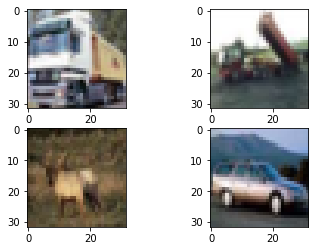

In [4]:
fig, axs = plt.subplots(2, 2) #Crea una matriz 2x2 para los subplots
axs[0,0].imshow(x_train[1])
axs[0,1].imshow(x_train[2])
axs[1,0].imshow(x_train[3])
axs[1,1].imshow(x_train[4])
plt.show()

Vamos a hacer una limpieza de datos comenzando por reducir la dimension de las imagenes. Sabemos que las matrices van de 0 a 255, entonces vamos a volver los numeros de 0 a 1 asi:

In [5]:
x_train = x_train.astype('float32')/255  #Quedaran imagenes de 32x32 en 3 distintas capas
x_test = x_test.astype('float32')/255

Vamos a reducir tambien o reestructurar los arreglos para los labels.

In [6]:
num_clases = len(np.unique(y_train)) #Hay 10 posibles numeros aca
y_train = to_categorical(y_train, num_clases) #To categorical vuelve los valores de clasificacion en un binario
y_test = to_categorical(y_test, num_clases) #Arreglo de 10 posibilidades donde marca el 1 donde esta la clase

Vamos a dividir nuestro set de entrenamiento en set de validacion, entrenamiento y test

In [7]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('x_train shape:', x_train.shape)

print('train:', x_train.shape[0]) #Usara 45000 imagenes
print('val:', x_valid.shape[0]) #Usara 5000 imagenes
print('test:', x_test.shape[0]) #Usara 10000 imagenes

x_train shape: (45000, 32, 32, 3)
train: 45000
val: 5000
test: 10000


Creacion de modelo

In [8]:
base_filtros = 32
w_regularizer = 1e-4

In [9]:
model = Sequential()
#Vamos a stakear capas

##CONVOLUCION 1
#en el parentesis hay: (Conv2D(#filtros, tamano de kernel, padding, kernel regularizer))
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer), input_shape=x_train.shape[1:])) 
#capa de activacion Relu
model.add(Activation('relu'))

##CONVOLUCION 2
#No necesita definir entrada porque esta se ve definida por la capa anterior
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#capa de maxpooling (Se hara cada 2 capas) para reducir la complejidad del modelo
model.add(MaxPooling2D(pool_size=(2,2))) #El pool size o kernel sera de 2x2
#capa de dropout para vigilar el overfiting
model.add(Dropout(0.2))

##CONVOLUCION 3
#Se hara mas profunda. El doble de filtros
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#capa de dropout
model.add(Dropout(0.2))

##CONVOLUCION 4
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#capa de maxpooling
model.add(MaxPooling2D(pool_size=(2,2)))
#capa de dropout
model.add(Dropout(0.3))

##CONVOLUCION 5
#Aun mas profunda. 4 veces mas filtros
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))

##CONVOLUCION 6
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#capa de maxpooling
model.add(MaxPooling2D(pool_size=(2,2)))
#capa de dropout
model.add(Dropout(0.4))

##CLASIFICACION Y FLATTEN
#capa flatten para agregar todo el resultado de la ultima convolucion se va a llevar a una unica dimension
model.add(Flatten())
#capa fully conect densa para la clasificacion de las imagenes
model.add(Dense(num_clases, activation='softmax'))

model.summary()


2023-01-25 12:40:34.946530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:40:34.947500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:40:35.140892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:40:35.141662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 12:40:35.142417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1